In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

Let's set up a problem using finite differences for 
$$
- u''(x) = f(x)
$$ with $u(0)=u(1)=0)$

This leads to the matrix equation for $n=7$ points
$$
\begin{bmatrix}
 2 & -1 & 0 & 0 & 0 & 0 & 0\\
-1 & 2 & -1 & 0 & 0 & 0 & 0\\
 0 & -1 & 2 & -1 & 0 & 0 & 0\\
 0 & 0 & -1 & 2 & -1 & 0 & 0\\
 0 & 0 & 0 & -1 & 2 & -1 & 0\\
 0 & 0 & 0 & 0 & -1 & 2 & -1\\
 0 & 0 & 0 & 0 & 0 & -1 & 2
\end{bmatrix}
\begin{bmatrix} u_1\\ u_2 \\ u_3 \\ u_4 \\ u_5 \\ u_6 \\ u_7 \end{bmatrix}
= h^2
\begin{bmatrix} f_1\\ f_2 \\ f_3 \\ f_4 \\ f_5 \\ f_6 \\ f_7 \end{bmatrix}
$$
or $A \vec{u} = \vec{f}$

## Define the matrix

Use a sparse matrix to set up $A$ above

In [85]:
k=7
n=2**k-1
v = np.ones(n)
A = sparse.diags_array((2*v, -v, -v), offsets=[0,-1,1], shape=(n,n)).tocsr()

## Define the matrix problem

Assume a random exact solution $u_{\text{exact}}$.  Then set the right-hand side $b$
so that $A u_{\text{exact}} = b$.

Next take $u$ to be a random guess at the solution.

In [204]:
np.random.seed(450)
uexact = np.random.rand(n)
b = A @ uexact
u0 = np.random.rand(n)
u = u0.copy()
err = [np.linalg.norm(u-uexact)]

## Look at smoothing

Consider the iteration
$$
u \leftarrow u + \omega D^{-1} (b - A u)
$$
for some $\omega$.  This is call (weighted) *Jacobi Iteration*.

In [205]:
omega = 2/3
for _ in range(10):
    u = u + omega * (1/2) * (b - A @ u)

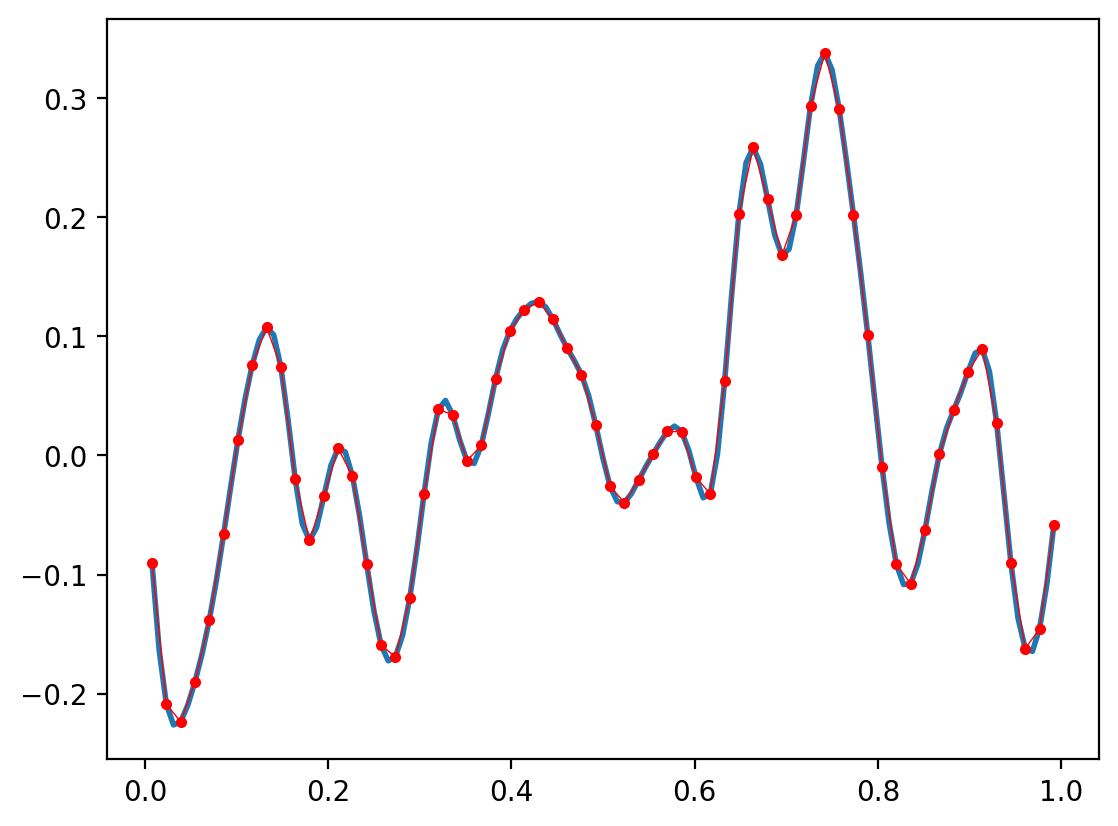

In [206]:
x = np.linspace(0, 1, n+2)
plt.plot(x[1:-1], u-uexact, '-', lw=2)
plt.plot(x[1:-1:2], (u-uexact)[::2], 'ro-', lw=0.5, ms=3)

Notice that the error is *smooth* (meaning low variation over many points).  This means that we can accurately represent the smooth error with fewer points.

## Set up a multigrid cycle

A multigrid iteration will proceed in the following way:
1. run a few iterations of weighted Jacobi to smooth the error
2. coarsen the residual
3. set up the coarse error problem and solve it
4. interpolate the coarse approximation to the error
5. correct the solution
6. run a few iterations of weighted Jacobi to smooth the error

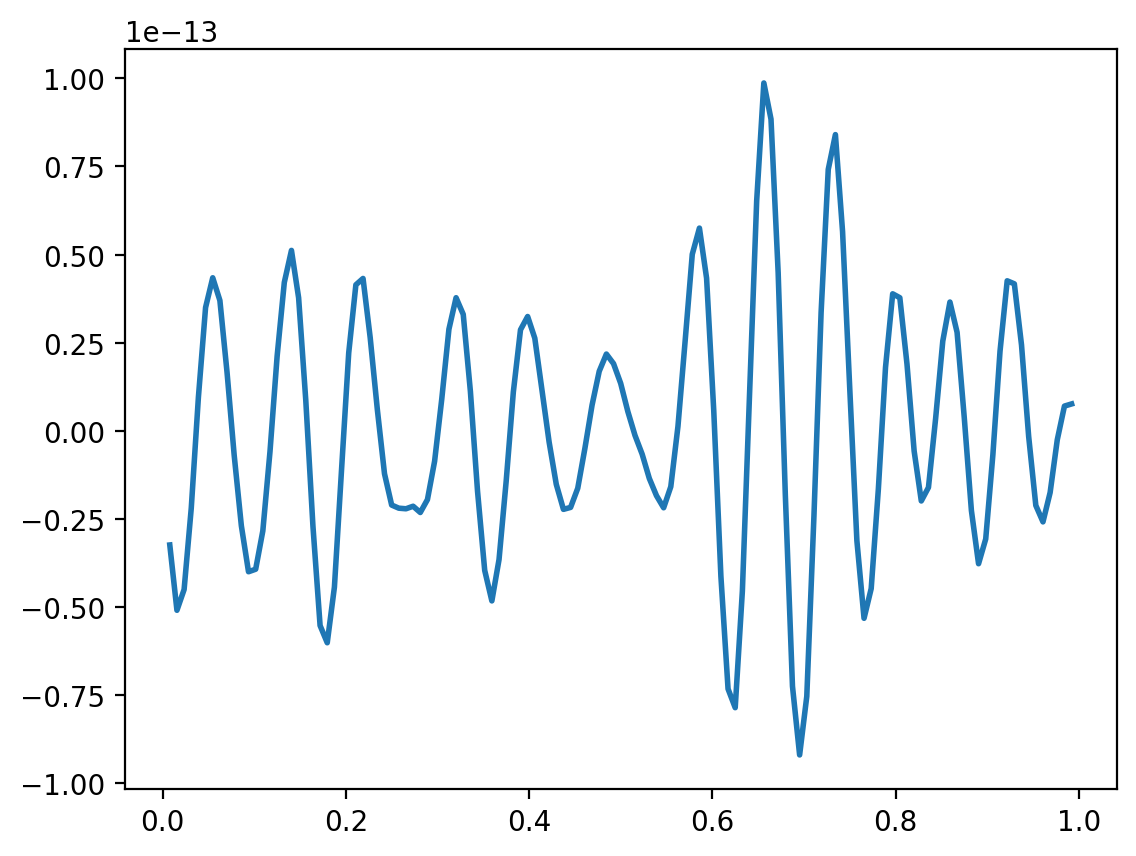

In [199]:
# 1.
for _ in range(3):
    u = u + omega * (1/2) * (b - A @ u)

# 2.
r = b - A @ u
rc = (2*r[1::2] + r[0:-1:2] + r[2::2])

# 3.
nc = len(rc)
v = np.ones(nc)
Ac = sparse.diags_array((2*v, -v, -v), offsets=[0,-1,1], shape=(nc,nc)).tocsr()
ec = sparse.linalg.spsolve(Ac, rc)

# 4.
e = np.zeros_like(u)
e[1::2] = ec
e[2:-2:2] = (ec[:-1] + ec[1:])/2
e[0] = ec[0]/2
e[-1] = ec[-1]/2

# 5.
u = u + e

# 6.
for _ in range(3):
    u = u + omega * (1/2) * (b - A @ u)

err.append(np.linalg.norm(u-uexact))
plt.plot(x[1:-1], u-uexact, '-', lw=2)

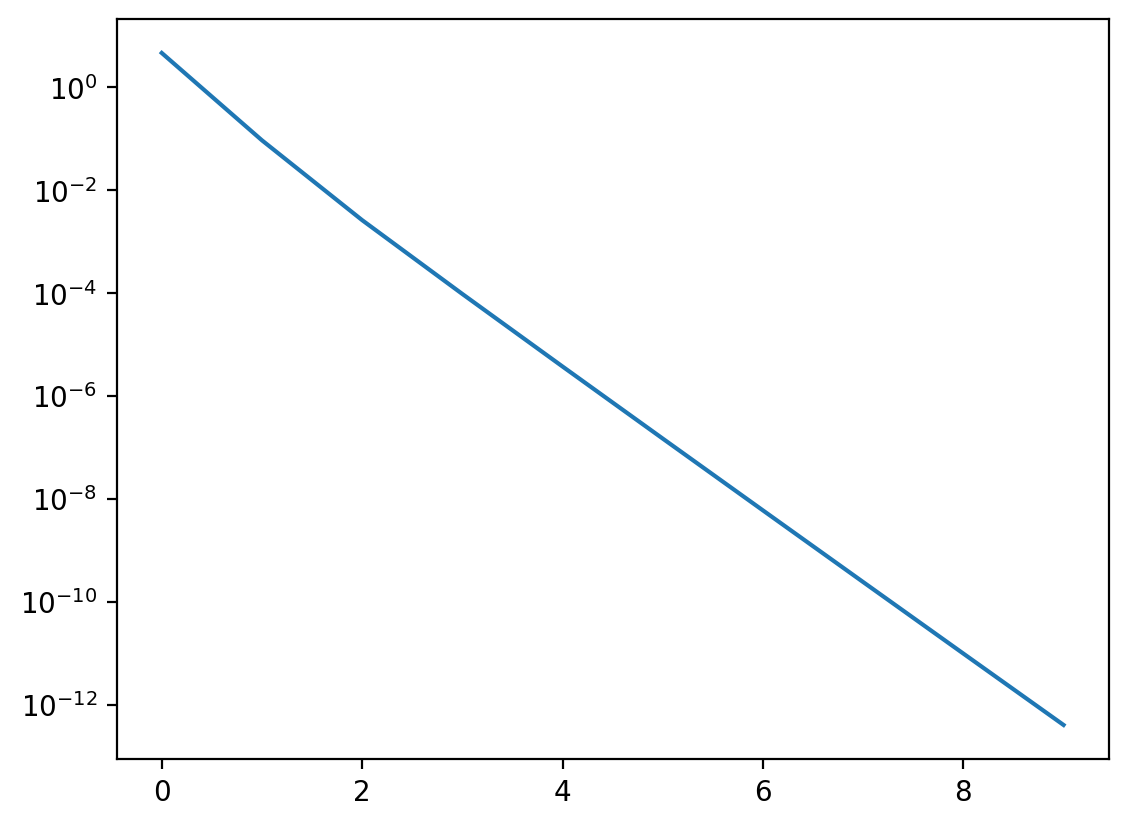

In [200]:
plt.semilogy(err)

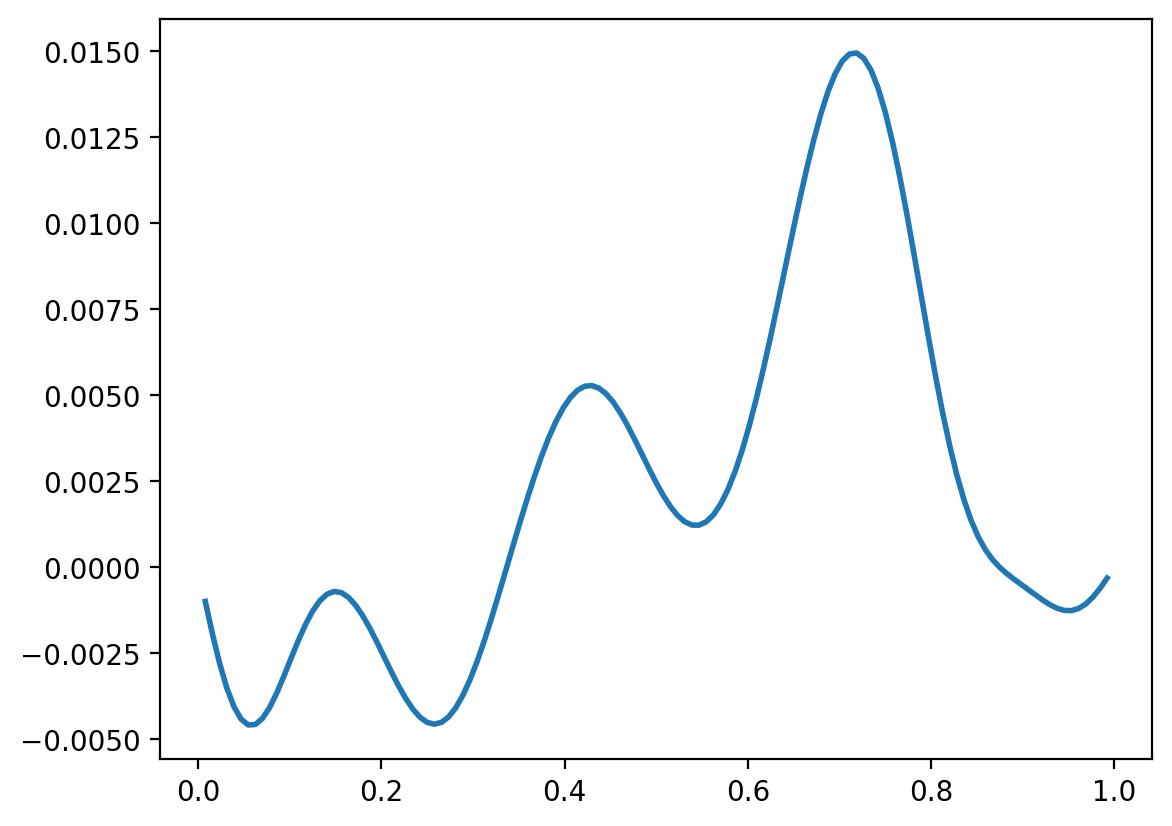